In [2]:
import torch
import torchvision
from torchvision import datasets, transforms, ops, models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm

In [12]:
BATCH_SIZE = 16
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 35
NAME_OF_MODEL = "shufflenet_v2_x0_5"

desired_size = 224
transform = transforms.Compose([transforms.Resize(desired_size),
                                transforms.Pad(padding=(desired_size - 224) // 2),
                                torchvision.transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])

trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [12]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [13]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [14]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


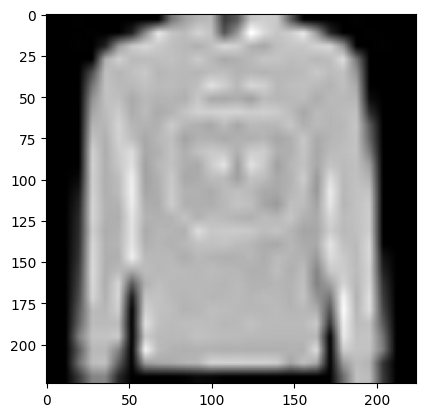

Label: 2


In [7]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7][0].squeeze()
label = train_labels[7]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
all_models = models.list_models()
m1 = models.shufflenet_v2_x0_5(num_classes=10)
# Move your model to the GPU if available
m1.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [18]:
batch1, label1=next(iter(trainloader))

In [22]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.fc.parameters():
    param.requires_grad = True

In [24]:
import pickle

batch_tr_loss = {}
batch_te_loss = {}
batch_sizes = [8, 16, 32, 64, 128]

for BATCH_SIZE in batch_sizes:

  m1 = models.shufflenet_v2_x0_5(num_classes=10)
  # Move your model to the GPU if available
  m1.to(device)

  optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
  loss_fn = torch.nn.CrossEntropyLoss()

  # Freeze all layers
  for param in m1.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in m1.fc.parameters():
      param.requires_grad = True

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
  testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

  # epoch loss and accuracy
  tr_loss, tr_acc = [], []
  te_loss, te_acc = [], []
  best_test_loss = float('inf')

  for t in (range(NUM_OF_EPOCHS)):
      m1.train()
      batch_loss, batch_accuracy = [], []
      print(f"Epoch {t+1} Training...")
      for X,y in tqdm(trainloader):
          X = X.to(device)
          y = y.to(device)
          predicted = m1(X)
          loss = loss_fn(predicted, y)
          batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
          batch_loss.append(float(loss.item()))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      batches = len(batch_loss)
      tr_loss.append(sum(batch_loss)/batches)
      tr_acc.append(sum(batch_accuracy)/batches)

      m1.eval()
      with torch.no_grad():
          batch_loss, batch_accuracy = [], []
          print(f"Epoch {t+1} Testing...")
          for X,y in tqdm(testloader):
              X = X.to(device)
              y = y.to(device)
              predicted = m1(X)
              loss = loss_fn(predicted, y)
              batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
              batch_loss.append(float(loss.item()))

          batches = len(batch_loss)
          te_loss.append(sum(batch_loss)/batches)
          te_acc.append(sum(batch_accuracy)/batches)

      model_weights_dir = f"model_weights/{NAME_OF_MODEL}"
      if not os.path.exists(model_weights_dir):
        os.makedirs(model_weights_dir)
      # Save the model's weights after each epoch
      torch.save(m1.state_dict(), f"{model_weights_dir}/{BATCH_SIZE}_model_weights.pth")

      # Check if the current test loss is the best so far
      if te_loss[-1] < best_test_loss:
          best_test_loss = te_loss[-1]
          # Save the model's weights with the best test loss
          torch.save(m1.state_dict(), f"{model_weights_dir}/{BATCH_SIZE}_best_model_weights.pth")

      print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")
  batch_tr_loss[BATCH_SIZE] = {"loss":tr_loss, "acc":tr_acc}
  batch_te_loss[BATCH_SIZE] = {"loss":te_loss, "acc":te_acc}

  training_info_dir = f"training_information/{NAME_OF_MODEL}"
  if not os.path.exists(training_info_dir):
    os.makedirs(training_info_dir)

  # Save the dictionary to a file
  with open(f"{training_info_dir}/batch_tr_loss.pkl", 'wb') as file:
      pickle.dump(batch_tr_loss, file)

  # Save the dictionary to a file
  with open(f"{training_info_dir}/batch_te_loss.pkl", 'wb') as file:
      pickle.dump(batch_te_loss, file)

Epoch 1 Training...


100%|██████████| 7500/7500 [02:00<00:00, 62.23it/s]


Epoch 1 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 85.62it/s] 


Epoch 1: Train_accuracy: 30.48%, Train_loss: 1.902928, Test_accuracy: 42.56%, Test_loss: 1.618851
Epoch 2 Training...


100%|██████████| 7500/7500 [01:37<00:00, 77.01it/s]


Epoch 2 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 86.67it/s] 


Epoch 2: Train_accuracy: 39.45%, Train_loss: 1.631368, Test_accuracy: 41.32%, Test_loss: 1.516311
Epoch 3 Training...


100%|██████████| 7500/7500 [01:33<00:00, 80.55it/s]


Epoch 3 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 67.00it/s] 


Epoch 3: Train_accuracy: 42.09%, Train_loss: 1.543233, Test_accuracy: 43.68%, Test_loss: 1.448626
Epoch 4 Training...


100%|██████████| 7500/7500 [03:06<00:00, 40.24it/s]


Epoch 4 Testing...


100%|██████████| 1250/1250 [00:27<00:00, 45.23it/s]


Epoch 4: Train_accuracy: 43.41%, Train_loss: 1.497567, Test_accuracy: 47.93%, Test_loss: 1.390992
Epoch 5 Training...


100%|██████████| 7500/7500 [03:13<00:00, 38.68it/s]


Epoch 5 Testing...


100%|██████████| 1250/1250 [00:27<00:00, 45.49it/s]


Epoch 5: Train_accuracy: 44.25%, Train_loss: 1.473378, Test_accuracy: 45.03%, Test_loss: 1.403904
Epoch 6 Training...


100%|██████████| 7500/7500 [03:10<00:00, 39.41it/s]


Epoch 6 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 51.02it/s] 


Epoch 6: Train_accuracy: 44.85%, Train_loss: 1.452457, Test_accuracy: 50.16%, Test_loss: 1.347474
Epoch 7 Training...


100%|██████████| 7500/7500 [01:34<00:00, 79.58it/s]


Epoch 7 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 78.76it/s] 


Epoch 7: Train_accuracy: 45.46%, Train_loss: 1.438739, Test_accuracy: 51.82%, Test_loss: 1.314571
Epoch 8 Training...


100%|██████████| 7500/7500 [02:09<00:00, 57.77it/s]


Epoch 8 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.88it/s] 


Epoch 8: Train_accuracy: 46.33%, Train_loss: 1.416642, Test_accuracy: 50.85%, Test_loss: 1.292221
Epoch 9 Training...


100%|██████████| 7500/7500 [01:40<00:00, 74.64it/s]


Epoch 9 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.58it/s]


Epoch 9: Train_accuracy: 46.60%, Train_loss: 1.404685, Test_accuracy: 51.44%, Test_loss: 1.284641
Epoch 10 Training...


100%|██████████| 7500/7500 [01:54<00:00, 65.77it/s]


Epoch 10 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 78.65it/s] 


Epoch 10: Train_accuracy: 46.56%, Train_loss: 1.407872, Test_accuracy: 51.32%, Test_loss: 1.293105
Epoch 11 Training...


100%|██████████| 7500/7500 [01:41<00:00, 74.21it/s]


Epoch 11 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 83.45it/s] 


Epoch 11: Train_accuracy: 46.74%, Train_loss: 1.399358, Test_accuracy: 51.17%, Test_loss: 1.269331
Epoch 12 Training...


100%|██████████| 7500/7500 [01:43<00:00, 72.37it/s]


Epoch 12 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 69.92it/s]


Epoch 12: Train_accuracy: 47.38%, Train_loss: 1.386947, Test_accuracy: 53.91%, Test_loss: 1.243822
Epoch 13 Training...


100%|██████████| 7500/7500 [01:39<00:00, 75.54it/s]


Epoch 13 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 69.91it/s] 


Epoch 13: Train_accuracy: 47.50%, Train_loss: 1.378785, Test_accuracy: 48.74%, Test_loss: 1.320085
Epoch 14 Training...


100%|██████████| 7500/7500 [01:31<00:00, 81.67it/s]


Epoch 14 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.20it/s] 


Epoch 14: Train_accuracy: 47.80%, Train_loss: 1.369524, Test_accuracy: 53.02%, Test_loss: 1.254122
Epoch 15 Training...


100%|██████████| 7500/7500 [01:33<00:00, 80.18it/s]


Epoch 15 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 84.41it/s] 


Epoch 15: Train_accuracy: 48.03%, Train_loss: 1.369377, Test_accuracy: 52.14%, Test_loss: 1.279966
Epoch 16 Training...


100%|██████████| 7500/7500 [01:37<00:00, 76.98it/s]


Epoch 16 Testing...


100%|██████████| 1250/1250 [00:15<00:00, 81.97it/s] 


Epoch 16: Train_accuracy: 48.36%, Train_loss: 1.360096, Test_accuracy: 52.92%, Test_loss: 1.248181
Epoch 17 Training...


100%|██████████| 7500/7500 [01:34<00:00, 79.40it/s]


Epoch 17 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 83.40it/s] 


Epoch 17: Train_accuracy: 48.42%, Train_loss: 1.354426, Test_accuracy: 51.14%, Test_loss: 1.291858
Epoch 18 Training...


100%|██████████| 7500/7500 [01:36<00:00, 77.66it/s]


Epoch 18 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 84.04it/s] 


Epoch 18: Train_accuracy: 48.41%, Train_loss: 1.354839, Test_accuracy: 50.55%, Test_loss: 1.395822
Epoch 19 Training...


100%|██████████| 7500/7500 [01:33<00:00, 79.88it/s]


Epoch 19 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 84.95it/s] 


Epoch 19: Train_accuracy: 48.41%, Train_loss: 1.351435, Test_accuracy: 54.51%, Test_loss: 1.222273
Epoch 20 Training...


100%|██████████| 7500/7500 [01:32<00:00, 80.72it/s]


Epoch 20 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.20it/s] 


Epoch 20: Train_accuracy: 48.41%, Train_loss: 1.350373, Test_accuracy: 53.49%, Test_loss: 1.239742
Epoch 21 Training...


100%|██████████| 7500/7500 [01:34<00:00, 79.35it/s]


Epoch 21 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 84.85it/s] 


Epoch 21: Train_accuracy: 48.80%, Train_loss: 1.341638, Test_accuracy: 52.59%, Test_loss: 1.237375
Epoch 22 Training...


100%|██████████| 7500/7500 [01:32<00:00, 80.82it/s]


Epoch 22 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.71it/s] 


Epoch 22: Train_accuracy: 49.06%, Train_loss: 1.338611, Test_accuracy: 52.80%, Test_loss: 1.286105
Epoch 23 Training...


100%|██████████| 7500/7500 [01:31<00:00, 81.66it/s]


Epoch 23 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 85.81it/s] 


Epoch 23: Train_accuracy: 49.25%, Train_loss: 1.334314, Test_accuracy: 54.99%, Test_loss: 1.185213
Epoch 24 Training...


100%|██████████| 7500/7500 [01:33<00:00, 80.10it/s]


Epoch 24 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 85.32it/s] 


Epoch 24: Train_accuracy: 49.29%, Train_loss: 1.334426, Test_accuracy: 52.22%, Test_loss: 1.288609
Epoch 25 Training...


100%|██████████| 7500/7500 [01:34<00:00, 79.21it/s]


Epoch 25 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.56it/s] 


Epoch 25: Train_accuracy: 49.32%, Train_loss: 1.334330, Test_accuracy: 50.82%, Test_loss: 1.299702
Epoch 26 Training...


100%|██████████| 7500/7500 [01:32<00:00, 81.09it/s]


Epoch 26 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 83.98it/s] 


Epoch 26: Train_accuracy: 49.29%, Train_loss: 1.328188, Test_accuracy: 53.96%, Test_loss: 1.254446
Epoch 27 Training...


100%|██████████| 7500/7500 [01:33<00:00, 80.01it/s]


Epoch 27 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 86.36it/s] 


Epoch 27: Train_accuracy: 49.65%, Train_loss: 1.324362, Test_accuracy: 54.59%, Test_loss: 1.201612
Epoch 28 Training...


100%|██████████| 7500/7500 [01:32<00:00, 81.23it/s]


Epoch 28 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 86.97it/s] 


Epoch 28: Train_accuracy: 49.48%, Train_loss: 1.328664, Test_accuracy: 51.20%, Test_loss: 1.268132
Epoch 29 Training...


100%|██████████| 7500/7500 [01:32<00:00, 81.17it/s]


Epoch 29 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 85.00it/s] 


Epoch 29: Train_accuracy: 49.57%, Train_loss: 1.322488, Test_accuracy: 53.84%, Test_loss: 1.244024
Epoch 30 Training...


100%|██████████| 7500/7500 [01:35<00:00, 78.67it/s]


Epoch 30 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 86.05it/s] 


Epoch 30: Train_accuracy: 49.72%, Train_loss: 1.319597, Test_accuracy: 55.85%, Test_loss: 1.200226
Epoch 31 Training...


100%|██████████| 7500/7500 [01:33<00:00, 79.94it/s]


Epoch 31 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 84.58it/s] 


Epoch 31: Train_accuracy: 49.85%, Train_loss: 1.315005, Test_accuracy: 51.58%, Test_loss: 1.299935
Epoch 32 Training...


100%|██████████| 7500/7500 [01:35<00:00, 78.84it/s]


Epoch 32 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 86.12it/s] 


Epoch 32: Train_accuracy: 50.13%, Train_loss: 1.313811, Test_accuracy: 54.75%, Test_loss: 1.232512
Epoch 33 Training...


100%|██████████| 7500/7500 [01:32<00:00, 81.34it/s]


Epoch 33 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 85.21it/s] 


Epoch 33: Train_accuracy: 50.05%, Train_loss: 1.313604, Test_accuracy: 52.45%, Test_loss: 1.250346
Epoch 34 Training...


100%|██████████| 7500/7500 [01:36<00:00, 77.69it/s]


Epoch 34 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.26it/s] 


Epoch 34: Train_accuracy: 50.30%, Train_loss: 1.306557, Test_accuracy: 55.43%, Test_loss: 1.177851
Epoch 35 Training...


100%|██████████| 7500/7500 [01:30<00:00, 82.52it/s]


Epoch 35 Testing...


100%|██████████| 1250/1250 [00:14<00:00, 87.64it/s] 


Epoch 35: Train_accuracy: 50.26%, Train_loss: 1.307793, Test_accuracy: 54.66%, Test_loss: 1.183850
Epoch 1 Training...


100%|██████████| 3750/3750 [00:57<00:00, 65.63it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:10<00:00, 57.45it/s]


Epoch 1: Train_accuracy: 31.46%, Train_loss: 1.895368, Test_accuracy: 34.42%, Test_loss: 1.704920
Epoch 2 Training...


100%|██████████| 3750/3750 [01:02<00:00, 59.61it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:10<00:00, 57.52it/s]


Epoch 2: Train_accuracy: 41.66%, Train_loss: 1.595871, Test_accuracy: 45.44%, Test_loss: 1.489957
Epoch 3 Training...


100%|██████████| 3750/3750 [01:01<00:00, 61.15it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.26it/s]


Epoch 3: Train_accuracy: 44.86%, Train_loss: 1.492866, Test_accuracy: 48.67%, Test_loss: 1.411119
Epoch 4 Training...


100%|██████████| 3750/3750 [01:02<00:00, 60.24it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:10<00:00, 57.27it/s]


Epoch 4: Train_accuracy: 46.36%, Train_loss: 1.440410, Test_accuracy: 47.99%, Test_loss: 1.371122
Epoch 5 Training...


100%|██████████| 3750/3750 [01:17<00:00, 48.17it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.61it/s]


Epoch 5: Train_accuracy: 47.35%, Train_loss: 1.407549, Test_accuracy: 52.44%, Test_loss: 1.286556
Epoch 6 Training...


100%|██████████| 3750/3750 [01:14<00:00, 50.52it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.63it/s]


Epoch 6: Train_accuracy: 48.24%, Train_loss: 1.382839, Test_accuracy: 49.68%, Test_loss: 1.376897
Epoch 7 Training...


100%|██████████| 3750/3750 [01:18<00:00, 47.50it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:15<00:00, 41.40it/s]


Epoch 7: Train_accuracy: 48.98%, Train_loss: 1.361590, Test_accuracy: 51.92%, Test_loss: 1.283360
Epoch 8 Training...


100%|██████████| 3750/3750 [01:28<00:00, 42.41it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.17it/s]


Epoch 8: Train_accuracy: 49.67%, Train_loss: 1.343621, Test_accuracy: 52.37%, Test_loss: 1.249377
Epoch 9 Training...


100%|██████████| 3750/3750 [01:26<00:00, 43.54it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:15<00:00, 41.54it/s]


Epoch 9: Train_accuracy: 49.64%, Train_loss: 1.332694, Test_accuracy: 53.53%, Test_loss: 1.252076
Epoch 10 Training...


100%|██████████| 3750/3750 [01:19<00:00, 47.20it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.69it/s]


Epoch 10: Train_accuracy: 50.32%, Train_loss: 1.321036, Test_accuracy: 52.94%, Test_loss: 1.247187
Epoch 11 Training...


100%|██████████| 3750/3750 [01:19<00:00, 46.98it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:14<00:00, 44.10it/s]


Epoch 11: Train_accuracy: 50.78%, Train_loss: 1.312303, Test_accuracy: 53.33%, Test_loss: 1.229025
Epoch 12 Training...


100%|██████████| 3750/3750 [01:20<00:00, 46.49it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.71it/s]


Epoch 12: Train_accuracy: 50.59%, Train_loss: 1.305468, Test_accuracy: 53.43%, Test_loss: 1.245050
Epoch 13 Training...


100%|██████████| 3750/3750 [01:30<00:00, 41.44it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.52it/s]


Epoch 13: Train_accuracy: 51.09%, Train_loss: 1.300553, Test_accuracy: 52.91%, Test_loss: 1.245485
Epoch 14 Training...


100%|██████████| 3750/3750 [01:58<00:00, 31.76it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:18<00:00, 32.99it/s]


Epoch 14: Train_accuracy: 51.20%, Train_loss: 1.290597, Test_accuracy: 53.25%, Test_loss: 1.223977
Epoch 15 Training...


100%|██████████| 3750/3750 [01:15<00:00, 49.38it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.33it/s]


Epoch 15: Train_accuracy: 51.61%, Train_loss: 1.282772, Test_accuracy: 52.72%, Test_loss: 1.265342
Epoch 16 Training...


100%|██████████| 3750/3750 [01:05<00:00, 57.66it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.99it/s]


Epoch 16: Train_accuracy: 51.62%, Train_loss: 1.277084, Test_accuracy: 54.29%, Test_loss: 1.216615
Epoch 17 Training...


100%|██████████| 3750/3750 [01:07<00:00, 55.39it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.19it/s]


Epoch 17: Train_accuracy: 51.92%, Train_loss: 1.273958, Test_accuracy: 56.08%, Test_loss: 1.184964
Epoch 18 Training...


100%|██████████| 3750/3750 [01:05<00:00, 57.26it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.21it/s]


Epoch 18: Train_accuracy: 52.23%, Train_loss: 1.264218, Test_accuracy: 54.37%, Test_loss: 1.200289
Epoch 19 Training...


100%|██████████| 3750/3750 [01:06<00:00, 56.72it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.63it/s]


Epoch 19: Train_accuracy: 52.19%, Train_loss: 1.265410, Test_accuracy: 56.48%, Test_loss: 1.163554
Epoch 20 Training...


100%|██████████| 3750/3750 [01:05<00:00, 57.48it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.71it/s]


Epoch 20: Train_accuracy: 52.64%, Train_loss: 1.253118, Test_accuracy: 55.29%, Test_loss: 1.187732
Epoch 21 Training...


100%|██████████| 3750/3750 [01:07<00:00, 55.52it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:12<00:00, 52.08it/s]


Epoch 21: Train_accuracy: 52.69%, Train_loss: 1.250016, Test_accuracy: 53.91%, Test_loss: 1.211781
Epoch 22 Training...


100%|██████████| 3750/3750 [01:07<00:00, 55.85it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.05it/s]


Epoch 22: Train_accuracy: 52.87%, Train_loss: 1.246044, Test_accuracy: 54.07%, Test_loss: 1.198086
Epoch 23 Training...


100%|██████████| 3750/3750 [01:08<00:00, 54.88it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.35it/s]


Epoch 23: Train_accuracy: 52.58%, Train_loss: 1.249896, Test_accuracy: 54.49%, Test_loss: 1.202763
Epoch 24 Training...


100%|██████████| 3750/3750 [01:08<00:00, 55.05it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.95it/s]


Epoch 24: Train_accuracy: 53.08%, Train_loss: 1.241560, Test_accuracy: 55.54%, Test_loss: 1.194448
Epoch 25 Training...


100%|██████████| 3750/3750 [01:06<00:00, 56.11it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.00it/s]


Epoch 25: Train_accuracy: 53.31%, Train_loss: 1.234598, Test_accuracy: 56.50%, Test_loss: 1.150431
Epoch 26 Training...


100%|██████████| 3750/3750 [01:04<00:00, 57.73it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:11<00:00, 54.98it/s]


Epoch 26: Train_accuracy: 53.41%, Train_loss: 1.236676, Test_accuracy: 56.27%, Test_loss: 1.152870
Epoch 27 Training...


100%|██████████| 3750/3750 [01:03<00:00, 59.09it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.63it/s]


Epoch 27: Train_accuracy: 53.56%, Train_loss: 1.227249, Test_accuracy: 56.36%, Test_loss: 1.154910
Epoch 28 Training...


100%|██████████| 3750/3750 [01:03<00:00, 58.72it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.97it/s]


Epoch 28: Train_accuracy: 53.65%, Train_loss: 1.229409, Test_accuracy: 54.79%, Test_loss: 1.206667
Epoch 29 Training...


100%|██████████| 3750/3750 [01:13<00:00, 50.84it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:16<00:00, 38.52it/s]


Epoch 29: Train_accuracy: 53.74%, Train_loss: 1.227206, Test_accuracy: 56.05%, Test_loss: 1.146738
Epoch 30 Training...


100%|██████████| 3750/3750 [01:19<00:00, 47.18it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.71it/s]


Epoch 30: Train_accuracy: 53.49%, Train_loss: 1.223227, Test_accuracy: 56.42%, Test_loss: 1.141817
Epoch 31 Training...


100%|██████████| 3750/3750 [01:18<00:00, 48.02it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:16<00:00, 37.24it/s]


Epoch 31: Train_accuracy: 54.07%, Train_loss: 1.216629, Test_accuracy: 54.41%, Test_loss: 1.197710
Epoch 32 Training...


100%|██████████| 3750/3750 [01:20<00:00, 46.87it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.19it/s]


Epoch 32: Train_accuracy: 54.02%, Train_loss: 1.222523, Test_accuracy: 55.43%, Test_loss: 1.141693
Epoch 33 Training...


100%|██████████| 3750/3750 [01:13<00:00, 51.15it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.33it/s]


Epoch 33: Train_accuracy: 53.94%, Train_loss: 1.217776, Test_accuracy: 55.85%, Test_loss: 1.171976
Epoch 34 Training...


100%|██████████| 3750/3750 [01:22<00:00, 45.23it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:16<00:00, 38.39it/s]


Epoch 34: Train_accuracy: 53.80%, Train_loss: 1.222362, Test_accuracy: 57.53%, Test_loss: 1.130640
Epoch 35 Training...


100%|██████████| 3750/3750 [01:21<00:00, 45.96it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.97it/s]


Epoch 35: Train_accuracy: 53.95%, Train_loss: 1.215545, Test_accuracy: 56.70%, Test_loss: 1.161566
Epoch 1 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.66it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:13<00:00, 23.85it/s]


Epoch 1: Train_accuracy: 33.33%, Train_loss: 1.894681, Test_accuracy: 47.64%, Test_loss: 1.625601
Epoch 2 Training...


100%|██████████| 1875/1875 [01:04<00:00, 28.99it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.21it/s]


Epoch 2: Train_accuracy: 43.59%, Train_loss: 1.586452, Test_accuracy: 46.51%, Test_loss: 1.508123
Epoch 3 Training...


100%|██████████| 1875/1875 [00:57<00:00, 32.43it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.35it/s]


Epoch 3: Train_accuracy: 46.37%, Train_loss: 1.480897, Test_accuracy: 48.63%, Test_loss: 1.428877
Epoch 4 Training...


100%|██████████| 1875/1875 [01:02<00:00, 29.89it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.14it/s]


Epoch 4: Train_accuracy: 48.18%, Train_loss: 1.420229, Test_accuracy: 50.59%, Test_loss: 1.368152
Epoch 5 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.65it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.94it/s]


Epoch 5: Train_accuracy: 49.33%, Train_loss: 1.378405, Test_accuracy: 52.67%, Test_loss: 1.319933
Epoch 6 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.37it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.36it/s]


Epoch 6: Train_accuracy: 50.21%, Train_loss: 1.348675, Test_accuracy: 50.83%, Test_loss: 1.315899
Epoch 7 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.36it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.24it/s]


Epoch 7: Train_accuracy: 50.84%, Train_loss: 1.326961, Test_accuracy: 53.52%, Test_loss: 1.272869
Epoch 8 Training...


100%|██████████| 1875/1875 [00:59<00:00, 31.75it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.81it/s]


Epoch 8: Train_accuracy: 51.31%, Train_loss: 1.307560, Test_accuracy: 53.64%, Test_loss: 1.255788
Epoch 9 Training...


100%|██████████| 1875/1875 [01:02<00:00, 30.14it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.82it/s]


Epoch 9: Train_accuracy: 52.12%, Train_loss: 1.295021, Test_accuracy: 54.83%, Test_loss: 1.237016
Epoch 10 Training...


100%|██████████| 1875/1875 [01:01<00:00, 30.39it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.03it/s]


Epoch 10: Train_accuracy: 52.26%, Train_loss: 1.281580, Test_accuracy: 50.14%, Test_loss: 1.291930
Epoch 11 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.46it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.50it/s]


Epoch 11: Train_accuracy: 52.89%, Train_loss: 1.269872, Test_accuracy: 54.71%, Test_loss: 1.227936
Epoch 12 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.07it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.35it/s]


Epoch 12: Train_accuracy: 53.23%, Train_loss: 1.258171, Test_accuracy: 55.49%, Test_loss: 1.208370
Epoch 13 Training...


100%|██████████| 1875/1875 [01:00<00:00, 31.21it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.87it/s]


Epoch 13: Train_accuracy: 53.40%, Train_loss: 1.251891, Test_accuracy: 53.99%, Test_loss: 1.219295
Epoch 14 Training...


100%|██████████| 1875/1875 [01:01<00:00, 30.30it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.95it/s]


Epoch 14: Train_accuracy: 53.45%, Train_loss: 1.245704, Test_accuracy: 55.17%, Test_loss: 1.199295
Epoch 15 Training...


100%|██████████| 1875/1875 [01:05<00:00, 28.67it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.35it/s]


Epoch 15: Train_accuracy: 53.83%, Train_loss: 1.238499, Test_accuracy: 53.00%, Test_loss: 1.238752
Epoch 16 Training...


100%|██████████| 1875/1875 [01:01<00:00, 30.45it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.38it/s]


Epoch 16: Train_accuracy: 53.90%, Train_loss: 1.233941, Test_accuracy: 54.60%, Test_loss: 1.201759
Epoch 17 Training...


100%|██████████| 1875/1875 [00:53<00:00, 34.83it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.75it/s]


Epoch 17: Train_accuracy: 54.34%, Train_loss: 1.228232, Test_accuracy: 52.50%, Test_loss: 1.240126
Epoch 18 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.59it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.46it/s]


Epoch 18: Train_accuracy: 54.41%, Train_loss: 1.221548, Test_accuracy: 55.40%, Test_loss: 1.206670
Epoch 19 Training...


100%|██████████| 1875/1875 [00:51<00:00, 36.55it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.70it/s]


Epoch 19: Train_accuracy: 54.47%, Train_loss: 1.215366, Test_accuracy: 56.53%, Test_loss: 1.179427
Epoch 20 Training...


100%|██████████| 1875/1875 [00:55<00:00, 33.82it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.82it/s]


Epoch 20: Train_accuracy: 54.58%, Train_loss: 1.215505, Test_accuracy: 54.76%, Test_loss: 1.189978
Epoch 21 Training...


100%|██████████| 1875/1875 [00:54<00:00, 34.18it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.00it/s]


Epoch 21: Train_accuracy: 55.24%, Train_loss: 1.201221, Test_accuracy: 55.97%, Test_loss: 1.172813
Epoch 22 Training...


100%|██████████| 1875/1875 [00:56<00:00, 33.45it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.95it/s]


Epoch 22: Train_accuracy: 54.94%, Train_loss: 1.203457, Test_accuracy: 56.62%, Test_loss: 1.170529
Epoch 23 Training...


100%|██████████| 1875/1875 [00:50<00:00, 36.83it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.21it/s]


Epoch 23: Train_accuracy: 54.78%, Train_loss: 1.204205, Test_accuracy: 56.37%, Test_loss: 1.181957
Epoch 24 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.43it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.70it/s]


Epoch 24: Train_accuracy: 55.28%, Train_loss: 1.195578, Test_accuracy: 57.60%, Test_loss: 1.140249
Epoch 25 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.77it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.59it/s]


Epoch 25: Train_accuracy: 55.15%, Train_loss: 1.192705, Test_accuracy: 56.53%, Test_loss: 1.163060
Epoch 26 Training...


100%|██████████| 1875/1875 [00:52<00:00, 35.64it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.25it/s]


Epoch 26: Train_accuracy: 55.48%, Train_loss: 1.189097, Test_accuracy: 56.14%, Test_loss: 1.161332
Epoch 27 Training...


100%|██████████| 1875/1875 [00:50<00:00, 37.08it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.09it/s]


Epoch 27: Train_accuracy: 55.49%, Train_loss: 1.186917, Test_accuracy: 56.05%, Test_loss: 1.163756
Epoch 28 Training...


100%|██████████| 1875/1875 [00:49<00:00, 37.96it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.94it/s]


Epoch 28: Train_accuracy: 55.79%, Train_loss: 1.178640, Test_accuracy: 57.11%, Test_loss: 1.145613
Epoch 29 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.68it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:10<00:00, 31.26it/s]


Epoch 29: Train_accuracy: 55.84%, Train_loss: 1.181411, Test_accuracy: 56.61%, Test_loss: 1.152729
Epoch 30 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.78it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.89it/s]


Epoch 30: Train_accuracy: 55.95%, Train_loss: 1.175986, Test_accuracy: 57.83%, Test_loss: 1.135340
Epoch 31 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.95it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.23it/s]


Epoch 31: Train_accuracy: 55.87%, Train_loss: 1.180161, Test_accuracy: 56.59%, Test_loss: 1.145185
Epoch 32 Training...


100%|██████████| 1875/1875 [00:47<00:00, 39.54it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.99it/s]


Epoch 32: Train_accuracy: 56.28%, Train_loss: 1.170521, Test_accuracy: 55.30%, Test_loss: 1.175241
Epoch 33 Training...


100%|██████████| 1875/1875 [00:47<00:00, 39.13it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.79it/s]


Epoch 33: Train_accuracy: 55.97%, Train_loss: 1.173548, Test_accuracy: 56.46%, Test_loss: 1.139223
Epoch 34 Training...


100%|██████████| 1875/1875 [00:48<00:00, 38.88it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:09<00:00, 32.20it/s]


Epoch 34: Train_accuracy: 56.31%, Train_loss: 1.168132, Test_accuracy: 57.49%, Test_loss: 1.138220
Epoch 35 Training...


100%|██████████| 1875/1875 [00:50<00:00, 36.95it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.34it/s]


Epoch 35: Train_accuracy: 56.02%, Train_loss: 1.172882, Test_accuracy: 56.64%, Test_loss: 1.151692
Epoch 1 Training...


100%|██████████| 938/938 [00:47<00:00, 19.84it/s]


Epoch 1 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.91it/s]


Epoch 1: Train_accuracy: 28.95%, Train_loss: 1.985208, Test_accuracy: 35.48%, Test_loss: 1.791013
Epoch 2 Training...


100%|██████████| 938/938 [00:48<00:00, 19.18it/s]


Epoch 2 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


Epoch 2: Train_accuracy: 40.32%, Train_loss: 1.688003, Test_accuracy: 42.88%, Test_loss: 1.612063
Epoch 3 Training...


100%|██████████| 938/938 [00:48<00:00, 19.27it/s]


Epoch 3 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


Epoch 3: Train_accuracy: 44.35%, Train_loss: 1.555607, Test_accuracy: 45.94%, Test_loss: 1.503110
Epoch 4 Training...


100%|██████████| 938/938 [00:45<00:00, 20.52it/s]


Epoch 4 Testing...


100%|██████████| 157/157 [00:09<00:00, 15.93it/s]


Epoch 4: Train_accuracy: 46.05%, Train_loss: 1.486447, Test_accuracy: 47.75%, Test_loss: 1.443062
Epoch 5 Training...


100%|██████████| 938/938 [00:45<00:00, 20.59it/s]


Epoch 5 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.02it/s]


Epoch 5: Train_accuracy: 47.55%, Train_loss: 1.435121, Test_accuracy: 45.69%, Test_loss: 1.449451
Epoch 6 Training...


100%|██████████| 938/938 [00:45<00:00, 20.64it/s]


Epoch 6 Testing...


100%|██████████| 157/157 [00:09<00:00, 15.84it/s]


Epoch 6: Train_accuracy: 47.97%, Train_loss: 1.401648, Test_accuracy: 47.95%, Test_loss: 1.394355
Epoch 7 Training...


100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


Epoch 7 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.66it/s]


Epoch 7: Train_accuracy: 48.94%, Train_loss: 1.378329, Test_accuracy: 48.11%, Test_loss: 1.366748
Epoch 8 Training...


100%|██████████| 938/938 [00:45<00:00, 20.53it/s]


Epoch 8 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


Epoch 8: Train_accuracy: 49.83%, Train_loss: 1.351847, Test_accuracy: 49.11%, Test_loss: 1.351790
Epoch 9 Training...


100%|██████████| 938/938 [00:45<00:00, 20.54it/s]


Epoch 9 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.44it/s]


Epoch 9: Train_accuracy: 50.02%, Train_loss: 1.334020, Test_accuracy: 50.95%, Test_loss: 1.324187
Epoch 10 Training...


100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


Epoch 10 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.75it/s]


Epoch 10: Train_accuracy: 50.40%, Train_loss: 1.322017, Test_accuracy: 51.49%, Test_loss: 1.309141
Epoch 11 Training...


100%|██████████| 938/938 [00:45<00:00, 20.67it/s]


Epoch 11 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.54it/s]


Epoch 11: Train_accuracy: 51.28%, Train_loss: 1.305523, Test_accuracy: 51.18%, Test_loss: 1.299973
Epoch 12 Training...


100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


Epoch 12 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.79it/s]


Epoch 12: Train_accuracy: 51.18%, Train_loss: 1.300244, Test_accuracy: 51.16%, Test_loss: 1.300558
Epoch 13 Training...


100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


Epoch 13 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


Epoch 13: Train_accuracy: 51.69%, Train_loss: 1.288295, Test_accuracy: 50.56%, Test_loss: 1.286717
Epoch 14 Training...


100%|██████████| 938/938 [00:51<00:00, 18.15it/s]


Epoch 14 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.91it/s]


Epoch 14: Train_accuracy: 52.10%, Train_loss: 1.278494, Test_accuracy: 50.56%, Test_loss: 1.288630
Epoch 15 Training...


100%|██████████| 938/938 [00:48<00:00, 19.34it/s]


Epoch 15 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch 15: Train_accuracy: 52.15%, Train_loss: 1.269977, Test_accuracy: 52.01%, Test_loss: 1.268429
Epoch 16 Training...


100%|██████████| 938/938 [00:47<00:00, 19.91it/s]


Epoch 16 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.13it/s]


Epoch 16: Train_accuracy: 52.36%, Train_loss: 1.264101, Test_accuracy: 51.75%, Test_loss: 1.269411
Epoch 17 Training...


100%|██████████| 938/938 [00:48<00:00, 19.38it/s]


Epoch 17 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


Epoch 17: Train_accuracy: 52.63%, Train_loss: 1.256705, Test_accuracy: 52.07%, Test_loss: 1.249982
Epoch 18 Training...


100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


Epoch 18 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


Epoch 18: Train_accuracy: 52.58%, Train_loss: 1.251383, Test_accuracy: 52.29%, Test_loss: 1.252585
Epoch 19 Training...


100%|██████████| 938/938 [00:47<00:00, 19.89it/s]


Epoch 19 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.32it/s]


Epoch 19: Train_accuracy: 52.85%, Train_loss: 1.247595, Test_accuracy: 52.14%, Test_loss: 1.247383
Epoch 20 Training...


100%|██████████| 938/938 [00:47<00:00, 19.69it/s]


Epoch 20 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.29it/s]


Epoch 20: Train_accuracy: 53.42%, Train_loss: 1.234978, Test_accuracy: 50.19%, Test_loss: 1.268443
Epoch 21 Training...


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch 21 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.20it/s]


Epoch 21: Train_accuracy: 53.75%, Train_loss: 1.231039, Test_accuracy: 52.02%, Test_loss: 1.243815
Epoch 22 Training...


100%|██████████| 938/938 [00:47<00:00, 19.64it/s]


Epoch 22 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.23it/s]


Epoch 22: Train_accuracy: 53.58%, Train_loss: 1.228533, Test_accuracy: 53.06%, Test_loss: 1.228774
Epoch 23 Training...


100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


Epoch 23 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.14it/s]


Epoch 23: Train_accuracy: 53.49%, Train_loss: 1.226524, Test_accuracy: 53.58%, Test_loss: 1.228020
Epoch 24 Training...


100%|██████████| 938/938 [00:48<00:00, 19.24it/s]


Epoch 24 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.58it/s]


Epoch 24: Train_accuracy: 53.45%, Train_loss: 1.225416, Test_accuracy: 54.29%, Test_loss: 1.218101
Epoch 25 Training...


100%|██████████| 938/938 [00:48<00:00, 19.21it/s]


Epoch 25 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.01it/s]


Epoch 25: Train_accuracy: 53.84%, Train_loss: 1.215145, Test_accuracy: 53.74%, Test_loss: 1.226315
Epoch 26 Training...


100%|██████████| 938/938 [00:50<00:00, 18.57it/s]


Epoch 26 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.34it/s]


Epoch 26: Train_accuracy: 54.02%, Train_loss: 1.212385, Test_accuracy: 53.99%, Test_loss: 1.206652
Epoch 27 Training...


100%|██████████| 938/938 [00:45<00:00, 20.54it/s]


Epoch 27 Testing...


100%|██████████| 157/157 [00:09<00:00, 16.28it/s]


Epoch 27: Train_accuracy: 54.21%, Train_loss: 1.208560, Test_accuracy: 54.96%, Test_loss: 1.198850
Epoch 28 Training...


100%|██████████| 938/938 [00:45<00:00, 20.56it/s]


Epoch 28 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


Epoch 28: Train_accuracy: 54.16%, Train_loss: 1.206476, Test_accuracy: 54.77%, Test_loss: 1.200282
Epoch 29 Training...


100%|██████████| 938/938 [00:46<00:00, 20.12it/s]


Epoch 29 Testing...


100%|██████████| 157/157 [00:11<00:00, 14.15it/s]


Epoch 29: Train_accuracy: 54.27%, Train_loss: 1.205577, Test_accuracy: 53.33%, Test_loss: 1.232965
Epoch 30 Training...


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch 30 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.89it/s]


Epoch 30: Train_accuracy: 54.41%, Train_loss: 1.202823, Test_accuracy: 53.97%, Test_loss: 1.207326
Epoch 31 Training...


100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


Epoch 31 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.95it/s]


Epoch 31: Train_accuracy: 54.52%, Train_loss: 1.199305, Test_accuracy: 54.46%, Test_loss: 1.195779
Epoch 32 Training...


100%|██████████| 938/938 [00:50<00:00, 18.46it/s]


Epoch 32 Testing...


100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


Epoch 32: Train_accuracy: 54.35%, Train_loss: 1.196924, Test_accuracy: 53.33%, Test_loss: 1.197155
Epoch 33 Training...


100%|██████████| 938/938 [00:49<00:00, 18.95it/s]


Epoch 33 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.95it/s]


Epoch 33: Train_accuracy: 54.87%, Train_loss: 1.191151, Test_accuracy: 54.74%, Test_loss: 1.184658
Epoch 34 Training...


100%|██████████| 938/938 [00:48<00:00, 19.16it/s]


Epoch 34 Testing...


100%|██████████| 157/157 [00:10<00:00, 15.18it/s]


Epoch 34: Train_accuracy: 55.15%, Train_loss: 1.186903, Test_accuracy: 54.02%, Test_loss: 1.218156
Epoch 35 Training...


100%|██████████| 938/938 [00:52<00:00, 17.77it/s]


Epoch 35 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.45it/s]


Epoch 35: Train_accuracy: 54.71%, Train_loss: 1.189492, Test_accuracy: 55.29%, Test_loss: 1.176069
Epoch 1 Training...


100%|██████████| 469/469 [00:47<00:00,  9.79it/s]


Epoch 1 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Epoch 1: Train_accuracy: 30.93%, Train_loss: 2.027594, Test_accuracy: 39.15%, Test_loss: 1.820389
Epoch 2 Training...


100%|██████████| 469/469 [00:52<00:00,  8.97it/s]


Epoch 2 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Epoch 2: Train_accuracy: 41.53%, Train_loss: 1.729081, Test_accuracy: 41.62%, Test_loss: 1.660784
Epoch 3 Training...


100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Epoch 3 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch 3: Train_accuracy: 44.70%, Train_loss: 1.595548, Test_accuracy: 47.21%, Test_loss: 1.534920
Epoch 4 Training...


100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 4 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


Epoch 4: Train_accuracy: 46.68%, Train_loss: 1.518351, Test_accuracy: 45.24%, Test_loss: 1.497673
Epoch 5 Training...


100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Epoch 5 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.28it/s]


Epoch 5: Train_accuracy: 48.34%, Train_loss: 1.463012, Test_accuracy: 48.35%, Test_loss: 1.444716
Epoch 6 Training...


100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


Epoch 6 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


Epoch 6: Train_accuracy: 48.75%, Train_loss: 1.425312, Test_accuracy: 49.60%, Test_loss: 1.409668
Epoch 7 Training...


100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


Epoch 7 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 7: Train_accuracy: 49.78%, Train_loss: 1.394375, Test_accuracy: 50.46%, Test_loss: 1.378188
Epoch 8 Training...


100%|██████████| 469/469 [00:58<00:00,  8.02it/s]


Epoch 8 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


Epoch 8: Train_accuracy: 50.34%, Train_loss: 1.372389, Test_accuracy: 51.03%, Test_loss: 1.361447
Epoch 9 Training...


100%|██████████| 469/469 [00:52<00:00,  9.01it/s]


Epoch 9 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Epoch 9: Train_accuracy: 50.92%, Train_loss: 1.353820, Test_accuracy: 52.23%, Test_loss: 1.337019
Epoch 10 Training...


100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Epoch 10 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Epoch 10: Train_accuracy: 51.45%, Train_loss: 1.335078, Test_accuracy: 52.06%, Test_loss: 1.322623
Epoch 11 Training...


100%|██████████| 469/469 [00:50<00:00,  9.27it/s]


Epoch 11 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Epoch 11: Train_accuracy: 51.75%, Train_loss: 1.323213, Test_accuracy: 52.25%, Test_loss: 1.312838
Epoch 12 Training...


100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


Epoch 12 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.11it/s]


Epoch 12: Train_accuracy: 52.05%, Train_loss: 1.308246, Test_accuracy: 51.32%, Test_loss: 1.302723
Epoch 13 Training...


100%|██████████| 469/469 [00:49<00:00,  9.41it/s]


Epoch 13 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Epoch 13: Train_accuracy: 52.84%, Train_loss: 1.292568, Test_accuracy: 52.34%, Test_loss: 1.299087
Epoch 14 Training...


100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


Epoch 14 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.30it/s]


Epoch 14: Train_accuracy: 53.13%, Train_loss: 1.287232, Test_accuracy: 52.29%, Test_loss: 1.284701
Epoch 15 Training...


100%|██████████| 469/469 [00:51<00:00,  9.07it/s]


Epoch 15 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


Epoch 15: Train_accuracy: 52.99%, Train_loss: 1.275745, Test_accuracy: 53.05%, Test_loss: 1.268067
Epoch 16 Training...


100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


Epoch 16 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.04it/s]


Epoch 16: Train_accuracy: 53.50%, Train_loss: 1.266389, Test_accuracy: 54.14%, Test_loss: 1.257437
Epoch 17 Training...


100%|██████████| 469/469 [00:48<00:00,  9.73it/s]


Epoch 17 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


Epoch 17: Train_accuracy: 53.55%, Train_loss: 1.259663, Test_accuracy: 50.87%, Test_loss: 1.281144
Epoch 18 Training...


100%|██████████| 469/469 [00:50<00:00,  9.32it/s]


Epoch 18 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Epoch 18: Train_accuracy: 53.54%, Train_loss: 1.253954, Test_accuracy: 52.44%, Test_loss: 1.263631
Epoch 19 Training...


100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Epoch 19 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.06it/s]


Epoch 19: Train_accuracy: 54.02%, Train_loss: 1.243106, Test_accuracy: 52.81%, Test_loss: 1.255033
Epoch 20 Training...


100%|██████████| 469/469 [00:47<00:00,  9.81it/s]


Epoch 20 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


Epoch 20: Train_accuracy: 53.92%, Train_loss: 1.241897, Test_accuracy: 53.15%, Test_loss: 1.243957
Epoch 21 Training...


100%|██████████| 469/469 [00:50<00:00,  9.36it/s]


Epoch 21 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Epoch 21: Train_accuracy: 54.32%, Train_loss: 1.234289, Test_accuracy: 52.66%, Test_loss: 1.258458
Epoch 22 Training...


100%|██████████| 469/469 [00:47<00:00,  9.79it/s]


Epoch 22 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.19it/s]


Epoch 22: Train_accuracy: 54.33%, Train_loss: 1.230738, Test_accuracy: 53.99%, Test_loss: 1.235611
Epoch 23 Training...


100%|██████████| 469/469 [00:49<00:00,  9.50it/s]


Epoch 23 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.11it/s]


Epoch 23: Train_accuracy: 54.50%, Train_loss: 1.224609, Test_accuracy: 54.58%, Test_loss: 1.223102
Epoch 24 Training...


100%|██████████| 469/469 [00:50<00:00,  9.26it/s]


Epoch 24 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Epoch 24: Train_accuracy: 54.68%, Train_loss: 1.218793, Test_accuracy: 55.31%, Test_loss: 1.219393
Epoch 25 Training...


100%|██████████| 469/469 [00:50<00:00,  9.24it/s]


Epoch 25 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


Epoch 25: Train_accuracy: 55.09%, Train_loss: 1.213345, Test_accuracy: 54.91%, Test_loss: 1.222150
Epoch 26 Training...


100%|██████████| 469/469 [00:52<00:00,  8.96it/s]


Epoch 26 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.08it/s]


Epoch 26: Train_accuracy: 55.06%, Train_loss: 1.206334, Test_accuracy: 55.18%, Test_loss: 1.214189
Epoch 27 Training...


100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Epoch 27 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.04it/s]


Epoch 27: Train_accuracy: 54.80%, Train_loss: 1.210842, Test_accuracy: 55.32%, Test_loss: 1.205240
Epoch 28 Training...


100%|██████████| 469/469 [00:50<00:00,  9.29it/s]


Epoch 28 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.16it/s]


Epoch 28: Train_accuracy: 55.24%, Train_loss: 1.203748, Test_accuracy: 54.52%, Test_loss: 1.212759
Epoch 29 Training...


100%|██████████| 469/469 [00:52<00:00,  8.97it/s]


Epoch 29 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.81it/s]


Epoch 29: Train_accuracy: 55.27%, Train_loss: 1.201211, Test_accuracy: 55.00%, Test_loss: 1.206796
Epoch 30 Training...


100%|██████████| 469/469 [00:50<00:00,  9.24it/s]


Epoch 30 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Epoch 30: Train_accuracy: 55.69%, Train_loss: 1.195341, Test_accuracy: 55.14%, Test_loss: 1.195578
Epoch 31 Training...


100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


Epoch 31 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


Epoch 31: Train_accuracy: 55.50%, Train_loss: 1.194412, Test_accuracy: 55.99%, Test_loss: 1.198180
Epoch 32 Training...


100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Epoch 32 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.34it/s]


Epoch 32: Train_accuracy: 55.46%, Train_loss: 1.194037, Test_accuracy: 56.59%, Test_loss: 1.185163
Epoch 33 Training...


100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Epoch 33 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


Epoch 33: Train_accuracy: 55.61%, Train_loss: 1.189390, Test_accuracy: 55.02%, Test_loss: 1.191181
Epoch 34 Training...


100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


Epoch 34 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


Epoch 34: Train_accuracy: 55.87%, Train_loss: 1.182258, Test_accuracy: 56.02%, Test_loss: 1.182469
Epoch 35 Training...


100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 35 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.65it/s]

Epoch 35: Train_accuracy: 56.41%, Train_loss: 1.177318, Test_accuracy: 54.73%, Test_loss: 1.186896


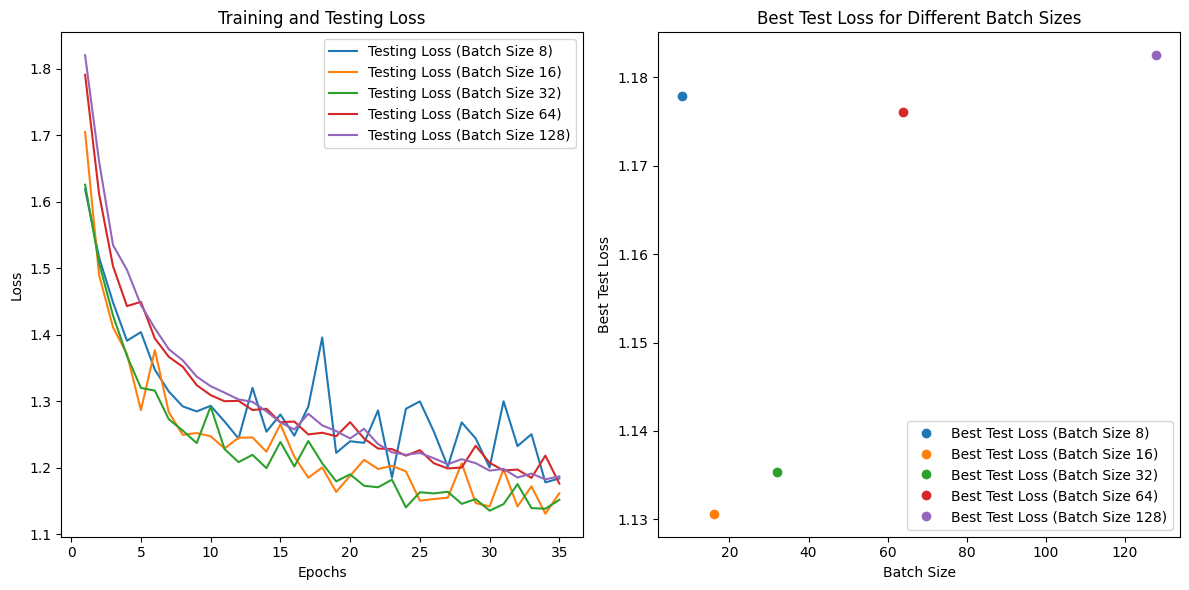

In [29]:
import matplotlib.pyplot as plt

# List of batch sizes
batch_sizes = [8, 16, 32, 64, 128]

# Plot test loss vs epoch for each batch size
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for batch_size in batch_sizes:
    # tr_loss = batch_tr_loss[batch_size]["loss"]
    te_loss = batch_te_loss[batch_size]["loss"]
    # plt.plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Loss (Batch Size {batch_size})')
    plt.plot(range(1, NUM_OF_EPOCHS + 1), te_loss, label=f'Testing Loss (Batch Size {batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot test acc vs epoch for each batch size
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for batch_size in batch_sizes:
    # tr_acc = batch_tr_loss[batch_size]["acc"]
    te_acc = batch_te_loss[batch_size]["acc"]
    # plt.plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Acc (Batch Size {batch_size})')
    plt.plot(range(1, NUM_OF_EPOCHS + 1), te_loss, label=f'Testing Acc (Batch Size {batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Plot the best test loss for each batch size
plt.subplot(1, 2, 2)
for batch_size in batch_sizes:
    best_test_loss = min(batch_te_loss[batch_size])
    plt.plot(batch_size, best_test_loss, 'o', label=f'Best Test Loss (Batch Size {batch_size})')
plt.xlabel('Batch Size')
plt.ylabel('Best Test Loss')
plt.title('Best Test Loss for Different Batch Sizes')
plt.legend()

# Plot the best test acc for each batch size
plt.subplot(1, 2, 2)
for batch_size in batch_sizes:
    best_test_loss = min(batch_te_loss[batch_size]["acc"])
    plt.plot(batch_size, best_test_loss, 'o', label=f'Best Test Acc (Batch Size {batch_size})')
plt.xlabel('Batch Size')
plt.ylabel('Best Test Loss')
plt.title('Best Test Loss for Different Batch Sizes')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('training_information/shufflenet_v2_x0_5/batch_loss_test_only_comparison_result.png', dpi=300)

### Unfreeze all layers, batch 16

In [9]:
import pickle

m1 = torchvision.models.get_model("shufflenet_v2_x0_5", num_classes=10)
# Move your model to the GPU if available
m1.to(device)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

# epoch loss and accuracy
tr_loss, tr_acc = [], []
te_loss, te_acc = [], []
best_test_loss = float('inf')
batch_tr_loss = {}
batch_te_loss = {}

early_stopping_patience = 30
early_stopping_counter = 0

NUM_OF_EPOCHS = 200
epoch_stopped_at = 0

for t in (range(NUM_OF_EPOCHS)):
    m1.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = m1(X)
        loss = loss_fn(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss.append(sum(batch_loss)/batches)
    tr_acc.append(sum(batch_accuracy)/batches)

    m1.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = m1(X)
            loss = loss_fn(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss.append(sum(batch_loss)/batches)
        te_acc.append(sum(batch_accuracy)/batches)

    model_weights_dir = f"model_weights/{NAME_OF_MODEL}/unfreeze_all_layer"

    if not os.path.exists(model_weights_dir):
        os.makedirs(model_weights_dir)
        # Save the model's weights after each epoch
        torch.save(m1.state_dict(), f"{model_weights_dir}/{BATCH_SIZE}_model_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss[-1] < best_test_loss:
        best_test_loss = te_loss[-1]
        early_stopping_counter = 0
        # Save the model's weights with the best test loss
        torch.save(m1.state_dict(), f"{model_weights_dir}/{BATCH_SIZE}_best_model_weights.pth")
    else:
        early_stopping_counter += 1

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")
    batch_tr_loss[BATCH_SIZE] = {"loss":tr_loss, "acc":tr_acc}
    batch_te_loss[BATCH_SIZE] = {"loss":te_loss, "acc":te_acc}

    training_info_dir = f"training_information/{NAME_OF_MODEL}/unfreeze_all_layer"
    if not os.path.exists(training_info_dir):
        os.makedirs(training_info_dir)

    # Save the dictionary to a file
    with open(f"{training_info_dir}/batch_tr_loss.pkl", 'wb') as file:
        pickle.dump(batch_tr_loss, file)

    # Save the dictionary to a file
    with open(f"{training_info_dir}/batch_te_loss.pkl", 'wb') as file:
        pickle.dump(batch_te_loss, file)

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered. No improvement for {early_stopping_patience} epochs.")
        epoch_stopped_at = t
        break

Epoch 1 Training...


100%|██████████| 1875/1875 [01:54<00:00, 16.44it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:16<00:00, 18.50it/s]


Epoch 1: Train_accuracy: 80.66%, Train_loss: 0.523659, Test_accuracy: 87.94%, Test_loss: 0.316696
Epoch 2 Training...


100%|██████████| 1875/1875 [02:23<00:00, 13.08it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:17<00:00, 18.13it/s]


Epoch 2: Train_accuracy: 89.05%, Train_loss: 0.302871, Test_accuracy: 90.13%, Test_loss: 0.268941
Epoch 3 Training...


100%|██████████| 1875/1875 [01:59<00:00, 15.69it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.62it/s]


Epoch 3: Train_accuracy: 90.53%, Train_loss: 0.257703, Test_accuracy: 90.99%, Test_loss: 0.250694
Epoch 4 Training...


100%|██████████| 1875/1875 [01:34<00:00, 19.83it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:10<00:00, 29.15it/s]


Epoch 4: Train_accuracy: 91.68%, Train_loss: 0.229881, Test_accuracy: 91.33%, Test_loss: 0.243430
Epoch 5 Training...


100%|██████████| 1875/1875 [01:28<00:00, 21.11it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.79it/s]


Epoch 5: Train_accuracy: 92.35%, Train_loss: 0.212771, Test_accuracy: 92.46%, Test_loss: 0.213090
Epoch 6 Training...


100%|██████████| 1875/1875 [01:44<00:00, 17.86it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.97it/s]


Epoch 6: Train_accuracy: 92.95%, Train_loss: 0.195364, Test_accuracy: 90.83%, Test_loss: 0.261437
Epoch 7 Training...


100%|██████████| 1875/1875 [01:44<00:00, 17.98it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 7: Train_accuracy: 93.42%, Train_loss: 0.182099, Test_accuracy: 92.28%, Test_loss: 0.220989
Epoch 8 Training...


100%|██████████| 1875/1875 [02:46<00:00, 11.24it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.26it/s]


Epoch 8: Train_accuracy: 93.92%, Train_loss: 0.166706, Test_accuracy: 92.91%, Test_loss: 0.200643
Epoch 9 Training...


100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:18<00:00, 17.35it/s]


Epoch 9: Train_accuracy: 94.30%, Train_loss: 0.154898, Test_accuracy: 92.93%, Test_loss: 0.204876
Epoch 10 Training...


100%|██████████| 1875/1875 [02:36<00:00, 11.96it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.14it/s]


Epoch 10: Train_accuracy: 94.64%, Train_loss: 0.146905, Test_accuracy: 92.38%, Test_loss: 0.211281
Epoch 11 Training...


100%|██████████| 1875/1875 [01:24<00:00, 22.21it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:09<00:00, 31.38it/s]


Epoch 11: Train_accuracy: 95.11%, Train_loss: 0.133941, Test_accuracy: 93.27%, Test_loss: 0.200946
Epoch 12 Training...


100%|██████████| 1875/1875 [01:22<00:00, 22.85it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.35it/s]


Epoch 12: Train_accuracy: 95.37%, Train_loss: 0.125276, Test_accuracy: 93.29%, Test_loss: 0.201197
Epoch 13 Training...


100%|██████████| 1875/1875 [02:12<00:00, 14.14it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.77it/s]


Epoch 13: Train_accuracy: 95.70%, Train_loss: 0.116504, Test_accuracy: 92.42%, Test_loss: 0.229522
Epoch 14 Training...


100%|██████████| 1875/1875 [02:14<00:00, 13.93it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.18it/s]


Epoch 14: Train_accuracy: 96.05%, Train_loss: 0.107663, Test_accuracy: 92.51%, Test_loss: 0.223967
Epoch 15 Training...


100%|██████████| 1875/1875 [01:29<00:00, 20.96it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.62it/s]


Epoch 15: Train_accuracy: 96.32%, Train_loss: 0.100149, Test_accuracy: 92.45%, Test_loss: 0.236019
Epoch 16 Training...


100%|██████████| 1875/1875 [02:28<00:00, 12.64it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.17it/s]


Epoch 16: Train_accuracy: 96.45%, Train_loss: 0.094450, Test_accuracy: 92.56%, Test_loss: 0.233284
Epoch 17 Training...


100%|██████████| 1875/1875 [02:14<00:00, 13.96it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.13it/s]


Epoch 17: Train_accuracy: 96.81%, Train_loss: 0.086576, Test_accuracy: 92.41%, Test_loss: 0.247600
Epoch 18 Training...


100%|██████████| 1875/1875 [01:50<00:00, 17.02it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.42it/s]


Epoch 18: Train_accuracy: 97.02%, Train_loss: 0.079374, Test_accuracy: 93.07%, Test_loss: 0.230978
Epoch 19 Training...


100%|██████████| 1875/1875 [01:27<00:00, 21.52it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.80it/s]


Epoch 19: Train_accuracy: 97.15%, Train_loss: 0.078006, Test_accuracy: 92.93%, Test_loss: 0.243993
Epoch 20 Training...


100%|██████████| 1875/1875 [01:41<00:00, 18.49it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:10<00:00, 28.87it/s]


Epoch 20: Train_accuracy: 97.32%, Train_loss: 0.071667, Test_accuracy: 92.38%, Test_loss: 0.256489
Epoch 21 Training...


100%|██████████| 1875/1875 [01:36<00:00, 19.47it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:12<00:00, 24.70it/s]


Epoch 21: Train_accuracy: 97.62%, Train_loss: 0.064693, Test_accuracy: 93.13%, Test_loss: 0.257927
Epoch 22 Training...


100%|██████████| 1875/1875 [01:26<00:00, 21.77it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.57it/s]


Epoch 22: Train_accuracy: 97.69%, Train_loss: 0.062773, Test_accuracy: 93.36%, Test_loss: 0.254426
Epoch 23 Training...


100%|██████████| 1875/1875 [01:25<00:00, 21.94it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.04it/s]


Epoch 23: Train_accuracy: 97.72%, Train_loss: 0.061960, Test_accuracy: 92.48%, Test_loss: 0.280647
Epoch 24 Training...


100%|██████████| 1875/1875 [01:31<00:00, 20.58it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:16<00:00, 19.24it/s]


Epoch 24: Train_accuracy: 97.90%, Train_loss: 0.057173, Test_accuracy: 92.03%, Test_loss: 0.276335
Epoch 25 Training...


100%|██████████| 1875/1875 [01:30<00:00, 20.63it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.11it/s]


Epoch 25: Train_accuracy: 97.95%, Train_loss: 0.054672, Test_accuracy: 92.65%, Test_loss: 0.279654
Epoch 26 Training...


100%|██████████| 1875/1875 [01:27<00:00, 21.35it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:11<00:00, 28.23it/s]


Epoch 26: Train_accuracy: 98.11%, Train_loss: 0.051095, Test_accuracy: 93.20%, Test_loss: 0.262658
Epoch 27 Training...


100%|██████████| 1875/1875 [01:29<00:00, 21.04it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:10<00:00, 30.91it/s]


Epoch 27: Train_accuracy: 98.10%, Train_loss: 0.051730, Test_accuracy: 92.60%, Test_loss: 0.287141
Epoch 28 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.20it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.14it/s]


Epoch 28: Train_accuracy: 98.24%, Train_loss: 0.047325, Test_accuracy: 92.78%, Test_loss: 0.282520
Epoch 29 Training...


100%|██████████| 1875/1875 [01:42<00:00, 18.21it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.67it/s]


Epoch 29: Train_accuracy: 98.33%, Train_loss: 0.046786, Test_accuracy: 92.92%, Test_loss: 0.281171
Epoch 30 Training...


100%|██████████| 1875/1875 [01:51<00:00, 16.83it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.37it/s]


Epoch 30: Train_accuracy: 98.42%, Train_loss: 0.044044, Test_accuracy: 92.87%, Test_loss: 0.296143
Epoch 31 Training...


100%|██████████| 1875/1875 [01:41<00:00, 18.48it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:13<00:00, 23.43it/s]


Epoch 31: Train_accuracy: 98.30%, Train_loss: 0.045457, Test_accuracy: 92.99%, Test_loss: 0.290746
Epoch 32 Training...


100%|██████████| 1875/1875 [01:55<00:00, 16.27it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:20<00:00, 15.34it/s]


Epoch 32: Train_accuracy: 98.44%, Train_loss: 0.041558, Test_accuracy: 93.15%, Test_loss: 0.288903
Epoch 33 Training...


100%|██████████| 1875/1875 [03:36<00:00,  8.67it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:22<00:00, 13.87it/s]


Epoch 33: Train_accuracy: 98.50%, Train_loss: 0.040757, Test_accuracy: 92.46%, Test_loss: 0.324134
Epoch 34 Training...


100%|██████████| 1875/1875 [02:32<00:00, 12.33it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.88it/s]


Epoch 34: Train_accuracy: 98.63%, Train_loss: 0.036675, Test_accuracy: 93.03%, Test_loss: 0.333241
Epoch 35 Training...


100%|██████████| 1875/1875 [02:15<00:00, 13.86it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.74it/s]


Epoch 35: Train_accuracy: 98.54%, Train_loss: 0.038520, Test_accuracy: 92.72%, Test_loss: 0.303345
Epoch 36 Training...


100%|██████████| 1875/1875 [01:34<00:00, 19.92it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.95it/s]


Epoch 36: Train_accuracy: 98.73%, Train_loss: 0.035483, Test_accuracy: 92.73%, Test_loss: 0.305166
Epoch 37 Training...


100%|██████████| 1875/1875 [02:20<00:00, 13.35it/s]


Epoch 37 Testing...


100%|██████████| 313/313 [00:13<00:00, 22.42it/s]


Epoch 37: Train_accuracy: 98.72%, Train_loss: 0.034370, Test_accuracy: 92.23%, Test_loss: 0.326516
Epoch 38 Training...


100%|██████████| 1875/1875 [02:24<00:00, 12.96it/s]


Epoch 38 Testing...


100%|██████████| 313/313 [00:16<00:00, 19.44it/s]

Epoch 38: Train_accuracy: 98.72%, Train_loss: 0.033943, Test_accuracy: 93.09%, Test_loss: 0.317300
Early stopping triggered. No improvement for 30 epochs.


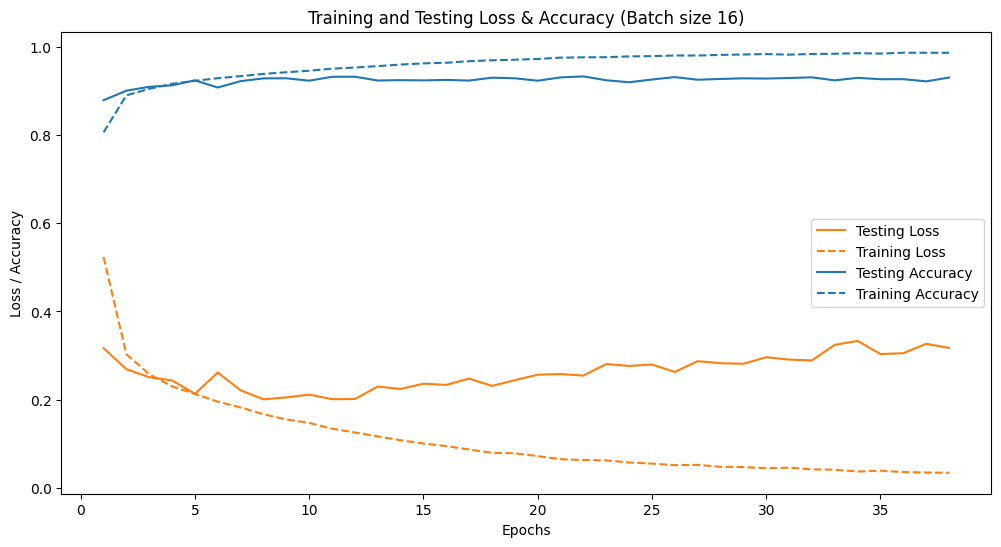

In [14]:
import matplotlib.pyplot as plt

file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_all_layer/batch_te_loss.pkl'

# Open the file in binary read mode ('rb')
with open(file_path, 'rb') as file:
    # Load the dictionary from the file
    batch_te_loss = pickle.load(file)

file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_all_layer/batch_tr_loss.pkl'

# Open the file in binary read mode ('rb')
with open(file_path, 'rb') as file:
    # Load the dictionary from the file
    batch_tr_loss = pickle.load(file)

# Specify the batch size you want to display
batch_size_to_display = 32

# Get the data for the specified batch size
te_loss = batch_te_loss[batch_size_to_display]["loss"]
te_acc = batch_te_loss[batch_size_to_display]["acc"]
tr_loss = batch_tr_loss[batch_size_to_display]["loss"]
tr_acc = batch_tr_loss[batch_size_to_display]["acc"]

# Create a single plot with combined training and testing information
plt.figure(figsize=(12, 6))

orange = 'tab:orange'  # Shades of orange
blue = 'tab:blue'      # An opposing color to orange

# Plot testing loss (shades of orange)
plt.plot(range(1, epoch_stopped_at + 2), te_loss, label=f'Testing Loss', color=orange)

# Plot training loss (shades of orange, different linestyle)
plt.plot(range(1, epoch_stopped_at + 2), tr_loss, label=f'Training Loss', linestyle='--', color=orange)

# Plot testing accuracy (shades of an opposing color)
plt.plot(range(1, epoch_stopped_at + 2), te_acc, label=f'Testing Accuracy', color=blue)

# Plot training accuracy (shades of an opposing color, different linestyle)
plt.plot(range(1, epoch_stopped_at + 2), tr_acc, label=f'Training Accuracy', linestyle='--', color=blue)


plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Testing Loss & Accuracy (Batch size 16)')
plt.legend()

plt.show()

## Try to apply Deformable Convolutions

Replace Conv2d with DeformConv2d

In [ ]:
import torch.nn as nn

m1 = models.shufflenet_v2_x0_5(num_classes=10)
m1.to(device)

def replace_conv2d_with_deformable_conv(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            # Create an offset layer for the deformable convolution
            offset_layer = nn.Conv2d(
                in_channels=2 * child.out_channels,  # 2 times the output channels
                out_channels=child.kernel_size[0] ** 2 * 2,  # Offset channels (h*w*2)
                kernel_size=child.kernel_size,
                stride=child.stride,
                padding=child.padding,
                dilation=child.dilation,
                groups=1,
                bias=True,  # You can set bias to True or False as per your requirements
            )

            # Create a deformable convolution layer with the same settings
            deform_conv = ops.DeformConv2d(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=child.kernel_size,
                stride=child.stride,
                padding=child.padding,
                dilation=child.dilation,
                groups=child.groups,
                bias=child.bias is not None,
            )
            deform_conv.weight = child.weight
            if child.bias is not None:
                deform_conv.bias = child.bias

            # Replace the Conv2d layer with the DeformConv2d layer
            setattr(module, name, offset_layer)
            new_name = name + '_deform'  # Modify the layer name
            setattr(module, new_name, deform_conv)
        else:
            # Recursively check children for Conv2d layers
            replace_conv2d_with_deformable_conv(child)

# Call the function to replace Conv2d layers with DeformConv2d layers
replace_conv2d_with_deformable_conv(m1)
m1